# Train model notebook

Source: 

- https://joeddav.github.io/blog/2020/05/29/ZSL.html
- https://huggingface.co/docs/setfit/how_to/zero_shot
- : Generic model 

Dataset:

- https://huggingface.co/docs/datasets/create_dataset

In [1]:
import pandas as pd
import re
import pandas as pd
import numpy as np
import re

ACRONYM = ["YTA", "YWBTA", "NTA", "YWNBTA", "ESH", "NAH", "INFO"]


def processing(doc):
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Suppression des mentions d'utilisateurs (par exemple, u/username)
    doc = re.sub(r'u/\S+', 'this people', doc)
    # Suppression des caractères spéciaux et de la ponctuation
    doc = re.sub(r'\W', ' ', doc)
    doc = re.sub(r'  ', ' ', doc)
    return doc


data = pd.read_pickle(f"./data/raw/post_0/comments.pkl")
data["label"] = data.label_user.astype("category").cat.codes
data = data[data['label'] != -1]

ACRONYM = ["YTA", "YWBTA", "NTA", "YWNBTA", "ESH", "NAH", "INFO"]

data["text"] = data.body.map(lambda x: re.sub("|".join(ACRONYM), "", x))

## Data enginerring
data = data[~data.body.isna()]

In [2]:
test_data = data.sample(int(0.3*data.shape[0]))
train_data = data[~data.index.isin(test_data.index)]

In [3]:
# source: https://huggingface.co/blog/setfit

from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset


MODEL ="sentence-transformers/paraphrase-albert-small-v2" 
# "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

test_ds = Dataset.from_dict({"text": test_data["text"].map(processing), "label": test_data["label"]}, split="test")
train_ds = Dataset.from_dict({"text": train_data["text"].map(processing), "label": train_data["label"]}, split="train")

model = SetFitModel.from_pretrained(MODEL)

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/romain/anaconda3/envs/projet/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/tmp/ipykernel_5006/759670283.py:16: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Map: 100%

In [6]:
trainer.train()

***** Running training *****
  Num unique pairs = 3080
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 193
  0%|          | 0/193 [00:00<?, ?it/s]

                                    

{'embedding_loss': 0.0037, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


{'embedding_loss': 0.0011, 'learning_rate': 1.6531791907514452e-05, 'epoch': 0.26}


{'embedding_loss': 0.0009, 'learning_rate': 1.0751445086705203e-05, 'epoch': 0.52}


{'embedding_loss': 0.0005, 'learning_rate': 4.971098265895954e-06, 'epoch': 0.78}



100%|██████████| 193/193 [00:30<00:00,  6.25it/s]


{'train_runtime': 30.8978, 'train_samples_per_second': 99.942, 'train_steps_per_second': 6.246, 'epoch': 1.0}


In [7]:
trainer.evaluate()

***** Running evaluation *****


{'accuracy': 0.42424242424242425}

## Analysis of result

In [27]:
model = trainer.model
model_old = SetFitModel.from_pretrained(MODEL)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [32]:
embeddings_after_train = model.encode(test_data.body.to_list())
embeddings_before_train = model_old.encode(test_data.body.to_list())

<Axes: >

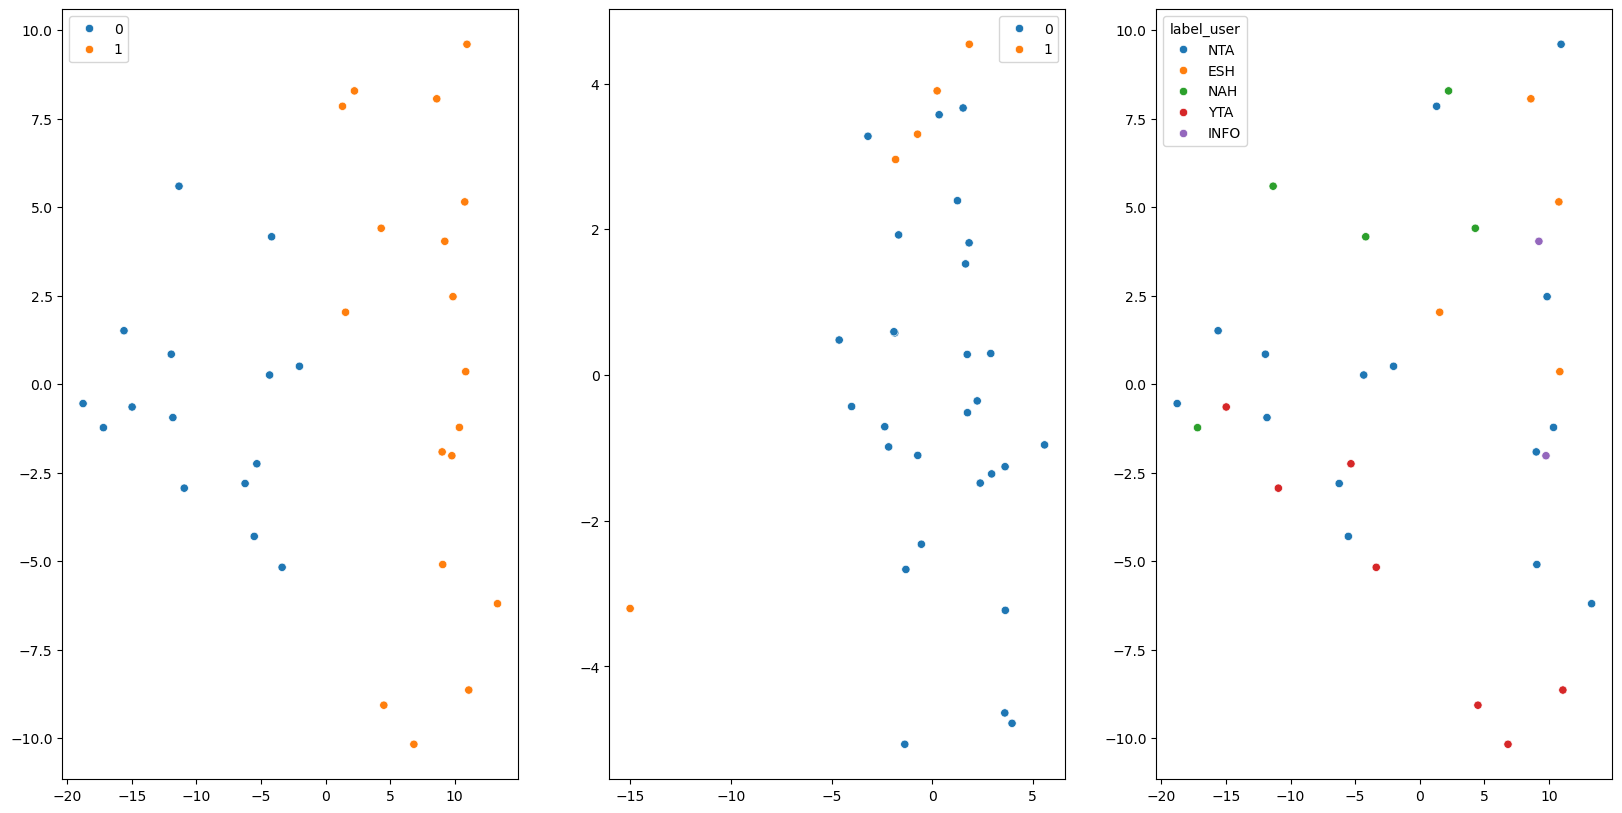

In [34]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def get_feature_and_prediction(embeddings):
    features = PCA(n_components=2).fit_transform(embeddings)
    pred = GaussianMixture(tol=0.001, n_components=2).fit_predict(features)
    return features, pred



plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
feature_train, pred_train = get_feature_and_prediction(embeddings_after_train)
sns.scatterplot(x=feature_train[:, 0], y=feature_train[:, 1], hue=pred_train)

plt.subplot(1, 3, 2)
feature_base, pred_base = get_feature_and_prediction(embeddings_before_train)
sns.scatterplot(x=feature_base[:, 0], y=feature_base[:, 1], hue = pred_base)


plt.subplot(1, 3, 3)
sns.scatterplot(x=feature_train[:, 0], y=feature_train[:, 1], hue = test_data.label_user)

In [ ]:

# source: https://huggingface.co/docs/setfit/how_to/zero_shot

# train_dataset = Dataset.from_dict({"text": data["body"], "label": data["label"]}, split="test").with_format("torch")
# dataloader = DataLoader(train_dataset, batch_size=4)
# train_dataloader = DataLoader(dataloader, shuffle=True, batch_size=16)


/home/romain/miniconda3/envs/projet/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
